# Vgg19 

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-19 19:25:55.278861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 19:25:55.283734: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 19:25:55.297837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 19:25:55.321913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 19:25:55.328716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 19:25:55.346820: I tensorflow/core/platform/cpu_feature_gu

In [2]:
import os
import json
from src.performance import *
from dotenv import load_dotenv

env = load_dotenv()

train_path = os.getenv('TRAIN_P')
test_path = os.getenv('TEST_P')
valid_path = os.getenv('VALID_P')
model_save_vgg19 = os.getenv('MODEL_SAVE_VGG19')
history_save_vgg19 = os.getenv('SAVE_HISTORY_VGG19')

env

True

data gen

In [3]:
# Initialize ImageDataGenerators
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Convert Keras ImageDataGenerator to tf.data.Dataset with .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, val_generator.num_classes), dtype=tf.float32)
    )
).repeat()

# Adjust steps_per_epoch and validation_steps if necessary
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

Found 3200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


pretrained models

In [4]:
# Import VGG19 model
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Build custom classification model on top of VGG19
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    model_save_vgg19,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0  
)

In [5]:
from keras.callbacks import Callback
from keras.optimizers import Adam

# Define a custom callback to adjust the learning rate based on validation accuracy
class AdjustLearningRate(Callback):
    def __init__(self, threshold=0.80, new_lr=0.00001):
        super(AdjustLearningRate, self).__init__()
        self.threshold = threshold  
        self.new_lr = new_lr        

    def on_epoch_end(self, epoch, logs=None):
       
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > self.threshold:
            current_lr = float(self.model.optimizer.learning_rate.numpy())
            

            if current_lr != self.new_lr:
                # print(f"\nValidation accuracy exceeded {self.threshold * 100:.2f}%. Changing learning rate from {current_lr} to {self.new_lr}.")
                self.model.optimizer.learning_rate = self.new_lr

In [6]:
# Build the Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(1024, activation='relu'),
    # Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Freeze the Base Model Layers Initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Checkpoint to Save the Best Model
checkpoint = ModelCheckpoint(
    model_save_vgg19,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)


# Custom Learning Rate Adjustment Callback
adjust_lr = AdjustLearningRate(threshold=0.80, new_lr=0.00001)

In [7]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[checkpoint,adjust_lr]
)

Epoch 1/10


/media/X/Research_coffee_classification/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-19 19:26:10.669557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-19 19:26:11.306046: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-09-19 19:26:11.792802: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-09-19 19:26:11.894503: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2

100/100 ━━━━━━━━━━━━━━━━━━━━ 498s 5s/step - accuracy: 0.3422 - loss: 1.3433 - val_accuracy: 0.7526 - val_loss: 0.9194
Epoch 2/10


2024-09-19 19:34:19.075604: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.8578
Epoch 3/10


2024-09-19 19:34:21.286306: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.5322 - loss: 0.9595 - val_accuracy: 0.8724 - val_loss: 0.7483
Epoch 4/10


2024-09-19 19:42:40.340765: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5866
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - accuracy: 0.6043 - loss: 0.8023 - val_accuracy: 0.8620 - val_loss: 0.7330
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5819
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 513s 5s/step - accuracy: 0.6208 - loss: 0.7820 - val_accuracy: 0.8047 - val_loss: 0.7222
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5640
Epoch 9/10


2024-09-19 19:59:47.154542: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - accuracy: 0.6062 - loss: 0.7840 - val_accuracy: 0.8229 - val_loss: 0.7113
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5505


In [8]:
# save history & final model

model.save(model_save_vgg19)

with open(history_save_vgg19, 'w') as file:
    json.dump(history.history, file)

print('model & history saved')

model & history saved


13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step
Confusion Matrix


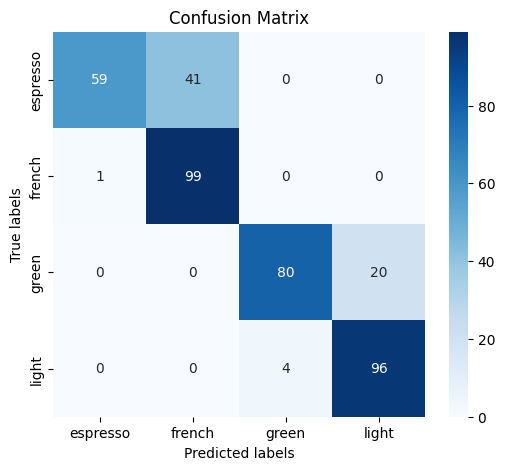

In [9]:
# all_measurement(history,model,test_generator)
plot_cf_matrix(model,test_generator)

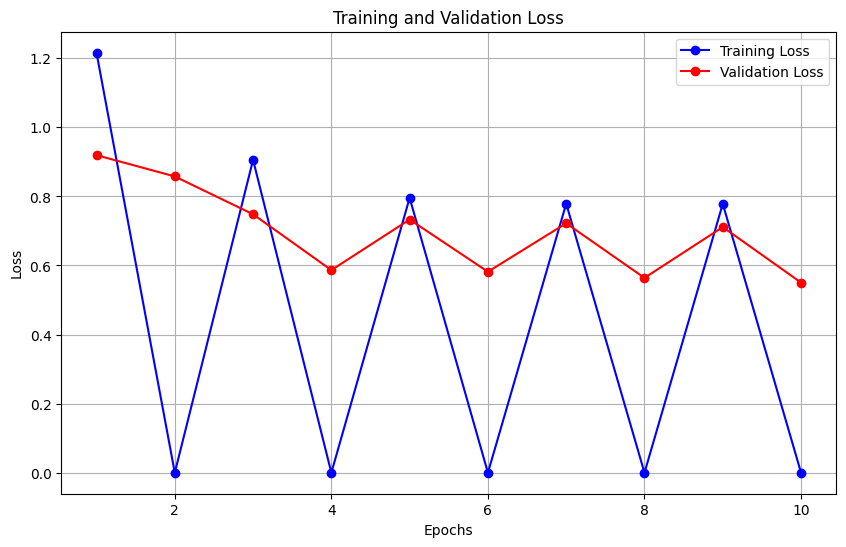

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
reports(model,test_datagen)

AttributeError: 'ImageDataGenerator' object has no attribute 'reset'

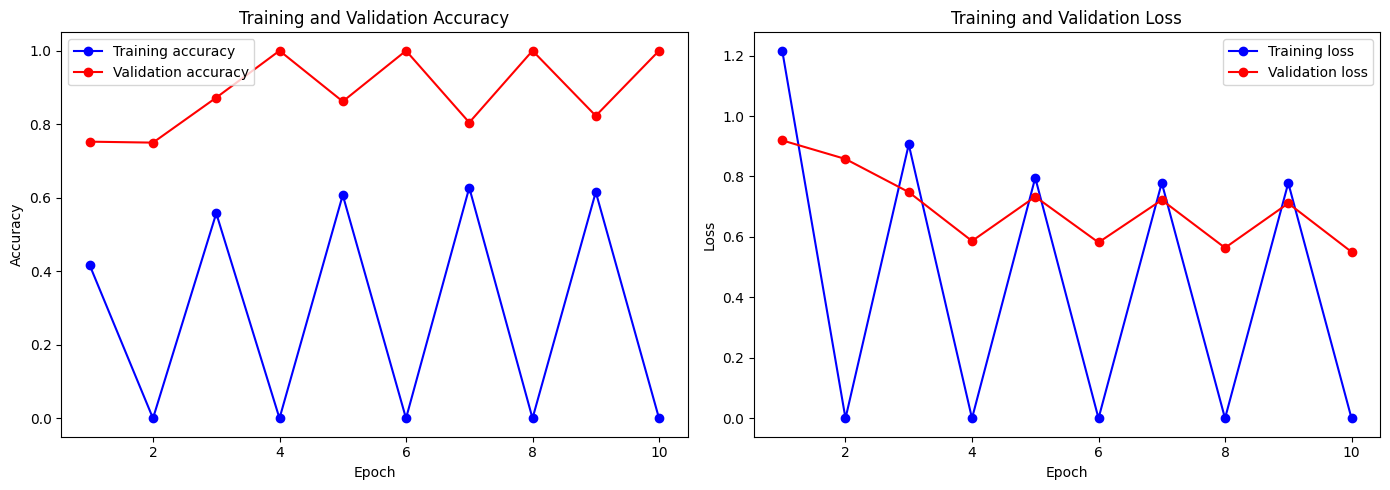

13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step
Confusion Matrix


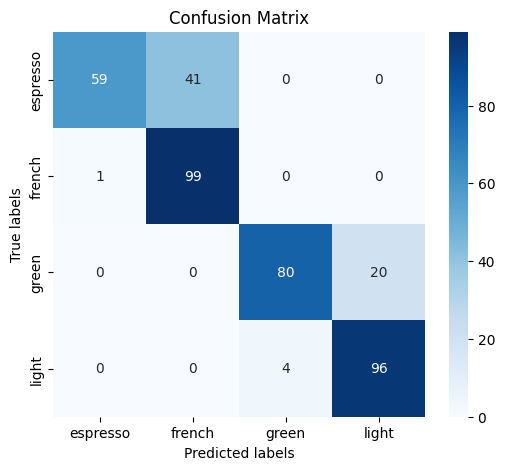

13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step
Classification Reports
              precision    recall  f1-score   support

    espresso       0.98      0.59      0.74       100
      french       0.71      0.99      0.82       100
       green       0.95      0.80      0.87       100
       light       0.83      0.96      0.89       100

    accuracy                           0.83       400
   macro avg       0.87      0.83      0.83       400
weighted avg       0.87      0.83      0.83       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7357 - loss: 0.7551
Test Accuracy: 0.8349999785423279
Test Loss: 0.7074902057647705
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step


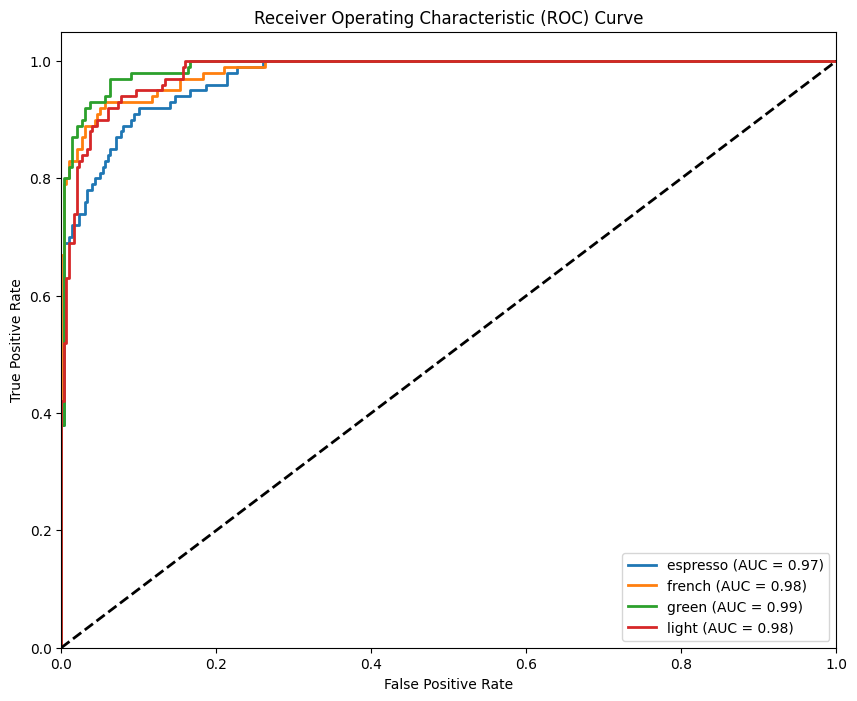

13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step
Misclassifications


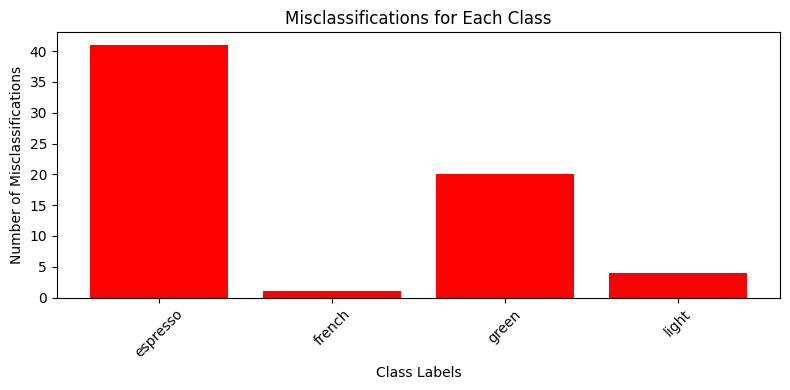

In [12]:
all_measurement(history,model,test_generator)